
Collaborative Filtering approach

Good source: https://developers.google.com/machine-learning/recommendation/collaborative/matrix

Model:
1. Map user ID to a "user vector" via an embedding matrix
2. Map book ID to a "book vector" via an embedding matrix
3. Compute the dot product between the user vector and book vector, to obtain the a match score between the user and the book (predicted rating).
4. Train the embeddings via gradient descent using all known user-book pairs.


## Libraries & Import

In [124]:
%cd bookai
!ls

/Users/laura/Desktop/5_sem/SoftwareEngineering/bookai
Books.csv   Ratings.csv Users.csv


In [3]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from pathlib import Path
import matplotlib.pyplot as plt
import json

In [125]:
# we are using the concanteted rating data (userid & isbn & bookrating) for training
book_df = pd.read_csv("Books.csv", names = ['ISBN', 'title', 'author', 'year_publication', 'publisher', 'img_s', 'img_m', 'img_l'], skiprows = 1)
    users = pd.read_csv("Users.csv")
df = pd.read_csv("Ratings.csv", names = ['userid','ISBN', 'bookrating'], skiprows = 1)
df.head()

/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,userid,ISBN,bookrating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


## Preprocessing

In [5]:
user_ids = df["userid"].unique().tolist() # List of all unique user id's
user2user_encoded = {x: i for i, x in enumerate(user_ids)} # map the unique user id's in sequence from 0 - n
userencoded2user = {i: x for i, x in enumerate(user_ids)}  # map the unique user id's from 0 - n (the other way around)

book_ids = df["ISBN"].unique().tolist()
book2book_encoded = {x: i for i, x in enumerate(book_ids)}
book_encoded2book = {i: x for i, x in enumerate(book_ids)}

df["user"] = df["userid"].map(user2user_encoded)
df["book"] = df["ISBN"].map(book2book_encoded)

In [6]:
df.head()

,userid,ISBN,bookrating,user,book
0,276725,034545104X,0,0,0
1,276726,0155061224,5,1,1
2,276727,0446520802,0,2,2
3,276729,052165615X,3,3,3
4,276729,0521795028,6,3,4


In [7]:
num_users = len(user2user_encoded)
num_books = len(book_encoded2book)
min_rating = min(df["bookrating"])
max_rating = max(df["bookrating"])

print("Number of users: {}, Number of books: {}, Min rating: {}, Max rating: {}".format(
        num_users, num_books, min_rating, max_rating))

Number of users: 105283, Number of books: 340556, Min rating: 0, Max rating: 10


In [8]:
df = df.sample(frac=1, random_state=42) # Shuffle the dataframe
x = df[["user", "book"]].values

# Normalize the targets between 0 and 1. Makes it easier to train.
y = df["bookrating"].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values

# Training on 80% of the data and validating on 20%.
train_indices = int(0.8 * len(df))
x_train, x_test, y_train, y_test = (
    x[:train_indices],
    x[train_indices:],
    y[:train_indices],
    y[train_indices:],
)

## Model & Training

In [ ]:
EMBEDDING_SIZE = 50 # Embeddings are vectors representing each book and user

class RecommenderNet(keras.Model): # Create subclass of Keras Model class
    def __init__(self, num_users, num_books, embedding_size):
        super(RecommenderNet, self).__init__() # Inherit from super class
        self.num_users = num_users
        self.num_books = num_books
        self.embedding_size = embedding_size
        
        # USERS embedding layer
        self.user_embedding = layers.Embedding( # Turns positive integers (indexes) into dense vectors of fixed size.
            num_users, # Input dimension
            embedding_size, # Output dimension
            embeddings_initializer = "he_normal", # Initializes the embeddings to random samples from a truncated normal distribution centered on 0 
            embeddings_regularizer = keras.regularizers.l2(1e-6), # Regularization prevents overfitting
        )
        self.user_bias = layers.Embedding(num_users, 1)
        
        # BOOKS embedding layer
        self.book_embedding = layers.Embedding(
            num_books, # Input dimension
            embedding_size, # Output dimension
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.book_bias = layers.Embedding(num_books, 1)

    def call(self, inputs): # initialization of layers and embeddings to be optimized in fit
        user_vector = self.user_embedding(inputs[:, 0]) # inputs = [user, book]
        user_bias = self.user_bias(inputs[:, 0])
        book_vector = self.book_embedding(inputs[:, 1])
        book_bias = self.book_bias(inputs[:, 1])
        dot_user_book = tf.tensordot(user_vector, book_vector, 2) # Matrix factorization # Dot products
        x = dot_user_book + user_bias + book_bias # Add all the components (including bias)
        return tf.nn.sigmoid(x) # The sigmoid activation forces the rating to between 0 and 1


model = RecommenderNet(num_users, num_books, EMBEDDING_SIZE)
model.compile(
    loss = tf.keras.losses.BinaryCrossentropy(), # Loss function used in optimization 
    optimizer = keras.optimizers.Adam(learning_rate = 0.001) # Adam optimization algorithm 
)

In [ ]:
history = model.fit(
    x = x_train,
    y = y_train,
    batch_size = 50, #Number of samples per gradient update
    epochs = 5,
    verbose = 1, # show training progression
    validation_data = (x_test, y_test),
)

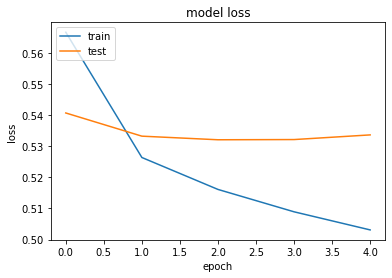

In [12]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()

In [57]:
# Trained model has been saved and can be loaded in

#model.save('collaborative_filtering_model')
#model = keras.models.load_model('collaborative_filtering_model')

## User Recommendations & JSON Output

In [107]:
# Get a random user and see the top recommendations.
user_id = df.userid.sample(1).iloc[0]  # Returns row id and userid, therefore we index with iloc
books_read_by_user = df[df.userid == user_id]
books_not_read = book_df[~book_df["ISBN"].isin(books_read_by_user.ISBN)]["ISBN"] # Extract all book ISBN that the user has NOT already read
books_not_read = list(set(books_not_read).intersection(set(book2book_encoded.keys()))) # If not done, 'predict' can't convert np array to tensor
books_not_read = [[book2book_encoded.get(x)] for x in books_not_read] # We have to get the encoded book ids, because that is what we fed the model
user_encoder = user2user_encoded.get(user_id) # Also get the encoded user id
user_book_array = np.hstack(([[user_encoder]] * len(books_not_read), books_not_read)) # Horizontal stack # concatenate the userid in one column and unread books in the other
ratings = model.predict(user_book_array).flatten() # Get rating predictions for each unread book # Flatten, or otherwise it will be an array of arrays
top_ratings_indices = ratings.argsort()[-10:][::-1] # Return indices of books in ascending order # get the last 10 (highest rating) # reverse order such that highest rated book is first
recommended_book_ids = [book_encoded2book.get(books_not_read[x][0]) for x in top_ratings_indices] # get original ISBN of the highest rated books

print("Showing recommendations for user: {}".format(user_id))
print("====" * 9)
print("books with high ratings from user")
print("----" * 8)
top_books_user = (
    books_read_by_user.sort_values(by="bookrating", ascending=False)
    .head(5)
    .ISBN.values
)
                      
book_df_rows = book_df[book_df["ISBN"].isin(top_books_user)]
for row in book_df_rows.itertuples():
    print(row.title, ":", row.author)

print("----" * 8)
print("Top 10 book recommendations")
print("----" * 8)
recommended_books = book_df[book_df["ISBN"].isin(recommended_book_ids)]
for row in recommended_books.itertuples():
    print(row.title, ":", row.author)


Showing recommendations for user: 95554
books with high ratings from user
--------------------------------
The Little Prince : Antoine de Saint-ExupÃ©ry
High Fidelity : Nick Hornby
The General in His Labyrinth (Penguin Great Books of the 20th Century) : Garcia Marques
The Pillars of Hercules: A Grand Tour of the Mediterranean : Paul Theroux
Mrs Keppel and Her Daughter : Diana Souhami
--------------------------------
Top 10 book recommendations
--------------------------------
One Fish Two Fish Red Fish Blue Fish (I Can Read It All by Myself Beginner Books) : DR SEUSS
Harry Potter and the Sorcerer's Stone (Book 1) : J. K. Rowling
Free : Paul Vincent
Harry Potter and the Prisoner of Azkaban (Book 3) : J. K. Rowling
Love You Forever : Robert N. Munsch
Falling Up : Shel Silverstein
A Kiss for Little Bear : Else Holmelund Minarik
There's Treasure Everywhere--A Calvin and Hobbes Collection : Bill Watterson
Harry Potter and the Chamber of Secrets Postcard Book : J. K. Rowling
Bloom County Bab

In [113]:
# Convert from numpy to python types in order to convert to JSON
recommendation_list = [isbn for isbn in recommended_books.ISBN]
rating_list = [isbn for isbn in top_books_user]


# Make python dict
rec_dict = {}
rec_dict['user_id'] = user_id.item()
rec_dict['high_rating_books_ISBN'] = rating_list
rec_dict['book_recommendations_ISBN'] = recommendation_list

# Convert python dict to json object
json_version = json.dumps(rec_dict, indent = 2)

print(json_version)

{
  "user_id": 95554,
  "high_rating_books_ISBN": [
    "0156528207",
    "1573225517",
    "0140148590",
    "0449910857",
    "0312195176"
  ],
  "book_recommendations_ISBN": [
    "0394800133",
    "0590353403",
    "1844262553",
    "0439136350",
    "0920668372",
    "0060248025",
    "0064440508",
    "0836213122",
    "0439425220",
    "0316103098"
  ]
}
